### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import math

### Load images

In [7]:
imsize = 128
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    
    return image.to(device, torch.float)

img_picasso = image_loader('./images/picasso.jpg')
img_klee = image_loader('./images/klee.jpg')
style_img = [img_picasso, img_klee]
content_img = image_loader('./images/dancing.jpg') 

for k in range(len(style_img)):
    assert style_img[k].size() == content_img.size()

### Display images

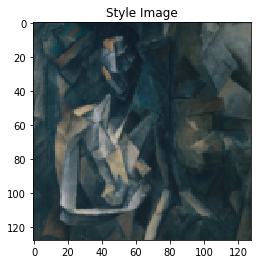

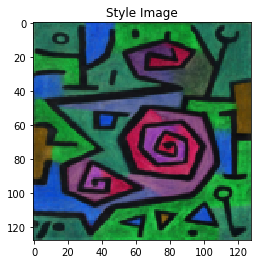

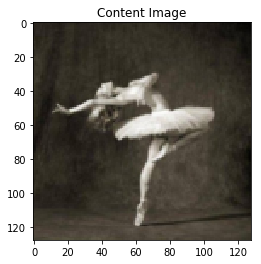

In [8]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

for k in range(len(style_img)):
    plt.figure()
    imshow(style_img[k], title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

### Define losses

I sort of understand 

In [9]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        if self.target.size() != input.size():
            target = self.target.expand(input.size())
        else:
            target = self.target
        
        
        self.loss = F.mse_loss(input, target)
        return input

In [10]:
a, b, c, d = 1, 2, 3, 3

m1 = torch.ones((a * b, math.floor(c * d / 2)))
m2 = torch.zeros((a * b, math.ceil(c * d / 2)))

T = torch.cat((m1, m2), dim=1)

torch.mul(1 - T, torch.ones(a * b, c * d))

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1.]])

In [11]:
def gram_matrix(input, T):
    a, b, c, d = input.size()  # a=batch size(=1)
    m, cp, dp = T.size()
    
    assert cp == c and dp == d
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    
    
    # Produce a spatial mask for the filter activations
    #m1 = torch.ones((a * b, math.floor(c * d / 2)))
    #m2 = torch.zeros((a * b, math.ceil(c * d / 2)))
    #T = torch.cat((m1, m2), dim=1)
    masked_input = torch.einsum('abcd,mcd->ambcd', [input, T])
    masked_features = masked_input.view(a, m, b, c * d)
    
    #features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    
    #masked_features = torch.mul(T.view(a * b, c * d), features)
    
    #G = torch.mm(masked_features, masked_features.t())  # compute the gram product
    G = torch.einsum('amik,amjk->amij', [masked_features, masked_features])

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    
    # Let gram_matrix output: batch x masks x spatial x spatial
    return G.div(b * c * d)

def target_gram(target_feature, T):
    m, b, c, d = target_feature.size()  # a=batch size(=1)
    mp, cp, dp = T.size() 
    
    assert mp == m and cp == c and dp == d
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    
    
    # Produce a spatial mask for the filter activations
    #m1 = torch.ones((a * b, math.floor(c * d / 2)))
    #m2 = torch.zeros((a * b, math.ceil(c * d / 2)))
    #T = torch.cat((m1, m2), dim=1)
    masked_input = torch.einsum('mbcd,mcd->mbcd', [target_feature, T])
    masked_features = masked_input.view(m, b, c * d)
    
    #features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    
    #masked_features = torch.mul(T.view(a * b, c * d), features)
    
    #G = torch.mm(masked_features, masked_features.t())  # compute the gram product
    G = torch.einsum('mik,mjk->mij', [masked_features, masked_features])
    

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    
    # Let gram_matrix output: batch x masks x spatial x spatial
    return G.div(b * c * d).unsqueeze(0)
    

class StyleLoss(nn.Module):

    def __init__(self, target_feature, mask):
        super(StyleLoss, self).__init__()
        self.target = []
        self.mask = mask
        #tf = torch.stack(target_feature).squeeze(1) # will have one too much dim

        self.target = target_gram(target_feature, mask).detach()
        
        

        #for k in range(len(target_feature)):
        #    self.target.append(gram_matrix(target_feature[k], mask[k]).detach())
        #    self.mask.append(mask[k])

    def forward(self, input):
        self.loss=0
        G = gram_matrix(input, self.mask)
        #print(G.size())
        #print(self.target.size())
        
        if self.target.size() != G.size():
            target = self.target.expand(G.size())
        else:
            target = self.target
        self.loss = F.mse_loss(G, target)
        
        return input

### Import pretrained model

In [12]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [13]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

No longer in use

def get_new_mask(old_mask, operation, kernel_size, stride, padding):
    if operation == 'Conv':
        unfold = torch.nn.Unfold(kernel_size=kernel_size, stride=stride, padding=padding)
        temp_mask = unfold(old_mask.unsqueeze(0).unsqueeze(0))
        temp_mask = temp_mask.mean(1)
        # Warning only works for square input
        out_size = int((old_mask.shape[0] - kernel_size + 2 * padding) / stride + 1)
        temp_mask = temp_mask.view(out_size, out_size)
        return temp_mask
    elif operation == 'MaxPooling':
        raise NotImplementedError
    else:
        raise NotImplementedError
        

In [42]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4']

def get_style_model_and_losses_lists(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default, spatial_mask=None):
    
    if spatial_mask is None:
        raise ValueError("A spatial mask must be provided")
        
    if len(spatial_mask) != len(style_img):
        raise ValueError("Number of spatial masks and number of style images must be equal")
    
    
    style_img = torch.stack(style_img).squeeze(1)
    
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    
    # We create a receptive averaging network whose input is the mask
    #receptive_averaging = nn.Sequential()#mask)
    
    # A list with the spatial masks for the style loss
    receptive_masks = [ [] for k in range(len(style_img)) ]
    receptive_masks = []
    layer_mask = spatial_mask
    receptive_masks.append(layer_mask)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        r_layer = None
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
            
            #r_name = 'conv_{}'.format(i)
            #r_layer = nn.Conv2d()
            #nn.AvgPool2d(layer.kernel_size,layer.stride)
            #layer_mask = get_new_mask(layer_mask, 'Conv', layer.kernel_size, layer.stride, layer.padding)
            
### how did you find that?
            r_avg = nn.AvgPool2d(layer.kernel_size,layer.stride, layer.padding)
            #layer_mask = r_avg(layer_mask.unsqueeze(0)).squeeze(0)
            layer_mask = r_avg(layer_mask)
            
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            
            #r_name = 'pool_{}'.format(i)
            #r_layer = layer
            #layer_mask = get_new_mask(layer_mask, 'MaxPooling', layer.kernel_size, layer.stride, layer.padding)
            r_max = nn.MaxPool2d(layer.kernel_size,layer.stride, layer.padding)
            #layer_mask = r_max(layer_mask.unsqueeze(0)).squeeze(0)
            layer_mask = r_max(layer_mask)
            
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        
        #if r_layer is not None:
        #    layer_mask = r_layer(layer_mask)
        #    receptive_masks.append(layer_mask)
            #receptive_averaging.add_module(r_name, r_layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:            
            
            # add style loss:
            target_feature = []
            
            target_feature = model(style_img).detach()
            
            #for k in range(len(style_img)):
            #    target_feature.append(model(style_img[k]).detach())
            
            style_loss = StyleLoss(target_feature, layer_mask)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]


    return model, style_losses, content_losses

The input to style loss should compute the same over everything in the batch dimension. 


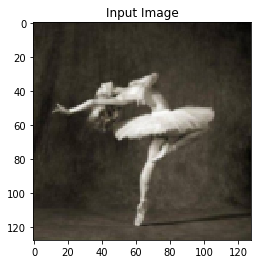

In [16]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)
#input_img = style_img.clone()


# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [17]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [21]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1, spatial_mask=None):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses_lists(cnn,
        normalization_mean, normalization_std, style_img, content_img, spatial_mask=spatial_mask)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

### Train with a square mask 

In [18]:
m1 = torch.ones((imsize, math.floor(imsize / 2)))
m2 = torch.zeros((imsize, math.ceil(imsize / 2)))
mask1 = torch.cat((m1, m2), dim=1)

m2o = torch.zeros((imsize, math.floor(imsize / 2)))
m2a = torch.ones((math.floor(imsize / 2),math.ceil(imsize/2)))
m2b = torch.zeros(((math.ceil(imsize / 2), math.ceil(imsize / 2))))
mask2 = torch.cat((m2o, torch.cat((m2a,m2b))), dim=1)

masks=[mask1, mask2]
masks = torch.stack(masks)

In [33]:
style_img = [img_picasso, img_klee]

Building the style transfer model..
16
13
13
Optimizing..
run [50]:
Style Loss : 1.548331 Content Loss: 12.983689

run [100]:
Style Loss : 1935666.625000 Content Loss: 457.309448

run [150]:
Style Loss : 2654260.750000 Content Loss: 467.757935

run [200]:
Style Loss : 107.435043 Content Loss: 33.797112

run [250]:
Style Loss : 15.758376 Content Loss: 23.706932

run [300]:
Style Loss : 6.460170 Content Loss: 21.791166



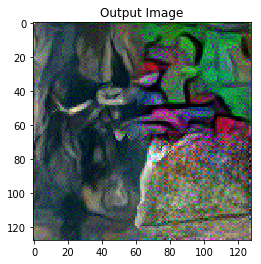

In [31]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, spatial_mask=masks)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

### Train with a circular mask

In [ ]:
def get_circular_mask(imsize):
    mask = torch.zeros(imsize, imsize)
    
    for i in range(imsize):
        for j in range(imsize):
            if (i - imsize/2)**2 + (j - imsize/2)**2 < 400:
                mask[i, j] = 1
                
    return mask

In [34]:
style_img = [img_klee]

In [35]:
masks = get_circular_mask(imsize).unsqueeze(0)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.001883 Content Loss: 30.399687

run [100]:
Style Loss : 2.143986 Content Loss: 14.737980

run [150]:
Style Loss : 1.641963 Content Loss: 9.462399

run [200]:
Style Loss : 1.406648 Content Loss: 7.705388

run [250]:
Style Loss : 1.340295 Content Loss: 6.848564

run [300]:
Style Loss : 1.336231 Content Loss: 6.328678



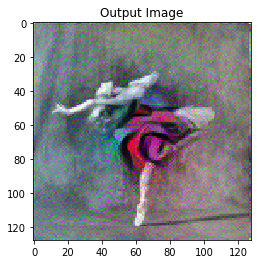

In [43]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, spatial_mask=masks)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()